In [46]:
#TODO
# - fazer analise com funções quadraticas simples
# - fazer analise com funções quadraticas criadas aleatoriamente
#     - criar função para gerar quadraticas convexas e nao convexas aleatoriamente (strongly convex é facil)
# - fazer calculo do gradiente da softmax
# - 

# Bibliotecas a serem usadas no projeto

In [47]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 

# Parte 1: gradiente descendente em funções quadráticas

Ao implementar um algoritmo de descida de gradiente, podemos escolher dentre diversos métodos para escolha do tamanho do passo a ser dado. Aqui, exploraremos dois deles: short-step e busca em linha exata.

## Preparação das funções quadráticas

Sabemos que para funções diferenciáveis, uma possível definição de convexidade forte é se a função pode ser cotada inferiormente por uma quadrática de coefficiente $m>0$. Em outras palavras, temos:

$$f(y) \geq f(x)+\nabla f(x)^T(y-x)+\frac{m}{2}\|y-x\|^2 \hspace{10pt} \forall x,y \in \text{Dom}(f)$$

Além disso, se a função é duplamente continuamente diferenciável - o que seria o caso neste exercício, já que lidamos apenas com quadráticas - uma outra maneira de caracterizar convexidade forte é pela propriedade

$$ \nabla^2 f(x) \succeq mI  \implies Q - mI \succeq 0. $$

Logo, teremos que definir $Q$ de tal modo que possua paenas autovalores positivos para os casos fortemente convexos, e pelo menos um autovalor nulo para o caso convexo. A função não convexa por sua vez possuirá pelo menos um autovalor negativo.

Para o caso apenas convexo, irrmos utilizar uma estratégia diferente para permitir a criação de matrizes automaticamente. Sabemos que podemos decompor uma matriz quadrada em função de seus autovalores e autovetores:

$$ Q = P \Lambda P^{-1} $$

onde $\Lambda$ é uma matriz diagonal de autovalores e $P$ é uma matriz ortogonal cujas colunas são os autovetores associados a cada autovalor. Podemos então partir de uma lista de autovalores e um conjunto qualquer de vetores ortogonais, e chegar a uma matrix qualquer. Abaixo, os vetores ortogonais podem ser gerados aleatoriamente por meio da decomposição QR de uma matriz aleatória. Essa estratégia poderia também ser usada para gerar matrizes aleatoriamente nos casos fortemente convexo e não-convexo, bastando a escolha correta da lista de autovalores.

In [48]:
def QuadraticFunction(x, Q, b, c):
    return x.T @ Q @ x + b.T @ x + c

def QuadraticGradient(x, Q, b):
    return Q @ x + b

def GeneratePSDMatrix(positiveEigValue:int=1):

    # Defining non-negative eigenvalues
    eigenvalues = np.array([positiveEigValue, 0])  
    
    # Generate a set of orthogonal vectors from the columns of an orthogonal matrix
    Q, R = np.linalg.qr(np.random.randn(2, 2), mode='complete') 
    
    # Recreate a matrix from the eigenvalues and orthogonal vectors.
    Q = Q @ np.diag(eigenvalues) @ Q.T
    return Q

def GenerateMatrixFromEigValues(eigValues:np.ndarray):

    # Generate a set of orthogonal vectors from the columns of an orthogonal matrix
    Q, R = np.linalg.qr(np.random.randn(2, 2), mode='complete') 
    
    # Recreate a matrix from the eigenvalues and orthogonal vectors.
    Q = Q @ np.diag(eigValues) @ Q.T
    return Q


## Implementação do gradiente descendente por descida mais íngrime:

In [49]:
def SteepestDescent(gradientNormStop, maxSteps, initialPoint, Q, b, c, objective, objectiveGradient, learningRate):
    """ 
    Implementação do algoritmo de descida de gradiente por descida mais íngrime e taxa de descida proporcional à constante de Lipschitz.
    Retorna também métricas de performance relevantes.
    """
    finalGradientNorms = []
    finalObjectiveValues = []
    iterations = []

    # Iteração zero do algoritmo
    point = initialPoint
    gradient = objectiveGradient(point, Q, b)
    gradientNorm = np.linalg.norm(gradient)

    iter = 1
    while iter < maxSteps and gradientNorm > gradientNormStop:
        
        if iter == 90:
            pass
        point = point - learningRate*gradient
        gradient = objectiveGradient(point, Q, b)
        gradientNorm = np.linalg.norm(gradient)

        iter = iter + 1
    
        finalGradientNorms.append(gradientNorm)
        finalObjectiveValues.append(objective(point, Q, b, c))
        iterations.append(iter)
        
    return finalGradientNorms, finalObjectiveValues, iterations

## Analisando um exemplo em cada caso de convexidade:

Iremos analisar aqui o comportamento da convergência do algoritmo de descida de gradiente com passo constante igual ao inverso da constante de Lipschitz da função objetivo. Faremos isso com base em duas desigualdades teóricas obtidas para funções convexas:

$$ f(x) - f(x^*) \leq \frac{L}{2T}|| x_0 - x^* || \hspace{1em} \text{(1)} $$
$$ f(x) - f(x^*) \leq \frac{2}{m}|| \nabla f(x) ||  \hspace{1em}\text{(2)} $$

onde $L$ é a constante de Lipschitz, $m$ o módulo de convexidade e $T$ o número de iterações.

Iremos considerar quadráticas simples, em duas dimensões, com termos linear e constante iguais a zero. O termo constante não influenciaria o processo de otimização de nenhuma forma, e o termo linear geraria apenas um deslocamento no ponto onde a função apresentaria seu mínimo. Além disso, a Hessiana terá autovetores colineares aos eixos x e y por comodidade, mas sabemos que uma Hessiana não diagonal pode sempre ser convertida para uma diagonal por uma mudança de base. Podemos então argumentar que os resultados obtidos aqui independem dessa escolha de base. 

### Caso fortemente convexo

In [50]:
# Preparando função fortemente convexa
Q = np.array([[5, 0],[0, 3]])
b = np.array([0,0])
c = 0
objective = QuadraticFunction
objectiveGradient = QuadraticGradient

# Calculando constante de Lipschitz e de convexidade
eigValues, eigvectors = np.linalg.eig(Q)
maxEig = np.max(eigValues)
minEig = np.min(eigValues)

# Hiperparâmetros da descida de gradiente
gradientNormStop = 1e-9
maxSteps = 100
initialPoint = np.array([1,1])
learningRate = 1/maxEig

finalGradientNorms, finalObjectiveValues, iterations = SteepestDescent(gradientNormStop, maxSteps, initialPoint, Q, b, c, objective, objectiveGradient, learningRate)

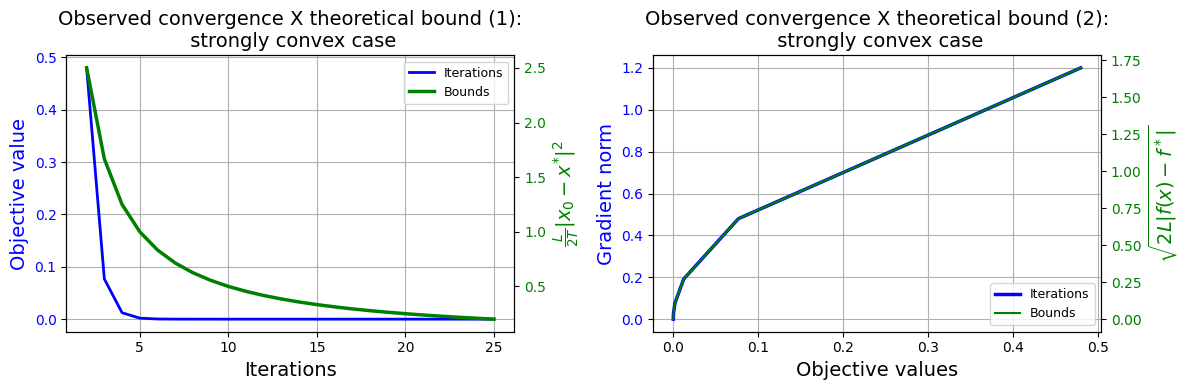

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4)) 

# Plot da relação entre iteração e valor da função objetivo (válido para os casos convexo e fortemente convexo)
ax1.plot(iterations, finalObjectiveValues, label='Iterations', color='blue', linewidth=2)
ax1.set_xlabel('Iterations', fontsize=14)
ax1.set_ylabel('Objective value', fontsize=14, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax1_twin = ax1.twinx()
ax1_twin.plot(iterations, maxEig / 2 * np.linalg.norm(initialPoint)**2 * (1 / np.array(iterations)), 
              label='Bounds', color='green', linewidth=2.5)
ax1_twin.set_ylabel('$\\frac{L}{2T}|x_0 - x^{*}|^2$', fontsize=14, color='green')
ax1_twin.tick_params(axis='y', labelcolor='green')

ax1.set_title('Observed convergence X theoretical bound (1):\n strongly convex case', fontsize=14)
ax1.grid(True)

lines1 = ax1.get_lines() + ax1_twin.get_lines()
labels1 = [line.get_label() for line in lines1]
ax1.legend(lines1, labels1, fontsize=9, loc='upper right')



# Plot da relação entre norma do gradiente e valor da função objetivo (válido para caso fortemente convexo)
ax2.plot(finalObjectiveValues, np.array(finalGradientNorms), label='Iterations', color='blue', linewidth=2.5)
ax2.set_xlabel('Objective values', fontsize=14)
ax2.set_ylabel('Gradient norm', fontsize=14, color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

ax2_twin = ax2.twinx()
ax2_twin.plot(finalObjectiveValues, np.sqrt(2 * minEig * np.array(finalObjectiveValues)), 
              label='Bounds', color='green', linewidth=1.5)
ax2_twin.set_ylabel('$\\sqrt{2L|f(x) - f^*|}$', fontsize=14, color='green')
ax2_twin.tick_params(axis='y', labelcolor='green')

ax2.set_title('Observed convergence X theoretical bound (2):\n strongly convex case', fontsize=14)
ax2.grid(True)

lines2 = ax2.get_lines() + ax2_twin.get_lines()
labels2 = [line.get_label() for line in lines2]
ax2.legend(lines2, labels2, fontsize=9, loc='lower right')



plt.tight_layout()
plt.show()

### Caso marginalmente convexo

In [52]:
# Preparando função fortemente convexa
Q = GenerateMatrixFromEigValues([2, 0.00001])
b = np.array([0,0])
c = 0
objective = QuadraticFunction
objectiveGradient = QuadraticGradient

# Calculando constante de Lipschitz e de convexidade
eigValues, eigvectors = np.linalg.eig(Q)
maxEig = np.max(eigValues)
minEig = np.min(eigValues)

# Hiperparâmetros da descida de gradiente
gradientNormStop = 1e-9
maxSteps = 100

initialPoint = np.array([1,1])
learningRate = 1/maxEig

finalGradientNorms, finalObjectiveValues, iterations = SteepestDescent(gradientNormStop, maxSteps, initialPoint, Q, b, c, objective, objectiveGradient, learningRate)

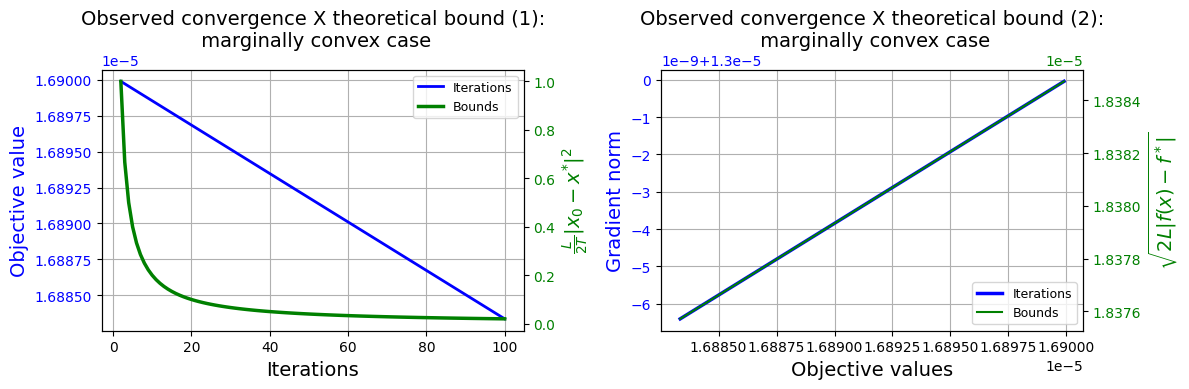

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4)) 

# Plot da relação entre iteração e valor da função objetivo (válido para os casos convexo e fortemente convexo)
ax1.plot(iterations, finalObjectiveValues, label='Iterations', color='blue', linewidth=2)
ax1.set_xlabel('Iterations', fontsize=14)
ax1.set_ylabel('Objective value', fontsize=14, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax1_twin = ax1.twinx()
ax1_twin.plot(iterations, maxEig / 2 * np.linalg.norm(initialPoint)**2 * (1 / np.array(iterations)), 
              label='Bounds', color='green', linewidth=2.5)
ax1_twin.set_ylabel('$\\frac{L}{2T}|x_0 - x^{*}|^2$', fontsize=14, color='green')
ax1_twin.tick_params(axis='y', labelcolor='green')

ax1.set_title('Observed convergence X theoretical bound (1):\n marginally convex case', fontsize=14)
ax1.grid(True)

lines1 = ax1.get_lines() + ax1_twin.get_lines()
labels1 = [line.get_label() for line in lines1]
ax1.legend(lines1, labels1, fontsize=9, loc='upper right')



# Plot da relação entre norma do gradiente e valor da função objetivo (válido para caso fortemente convexo)
ax2.plot(finalObjectiveValues, np.array(finalGradientNorms), label='Iterations', color='blue', linewidth=2.5)
ax2.set_xlabel('Objective values', fontsize=14)
ax2.set_ylabel('Gradient norm', fontsize=14, color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

ax2_twin = ax2.twinx()
ax2_twin.plot(finalObjectiveValues, np.sqrt(2 * minEig * np.array(finalObjectiveValues)), 
              label='Bounds', color='green', linewidth=1.5)
ax2_twin.set_ylabel('$\\sqrt{2L|f(x) - f^*|}$', fontsize=14, color='green')
ax2_twin.tick_params(axis='y', labelcolor='green')

ax2.set_title('Observed convergence X theoretical bound (2):\n marginally convex case', fontsize=14)
ax2.grid(True)

lines2 = ax2.get_lines() + ax2_twin.get_lines()
labels2 = [line.get_label() for line in lines2]
ax2.legend(lines2, labels2, fontsize=9, loc='lower right')



plt.tight_layout()
plt.show()

### Caso não convexo

In [54]:
# Preparando função fortemente convexa
Q = GenerateMatrixFromEigValues([2, -3])
b = np.array([0,0])
c = 0
objective = QuadraticFunction
objectiveGradient = QuadraticGradient

# Calculando constante de Lipschitz e de convexidade
eigValues, eigvectors = np.linalg.eig(Q)
maxEig = np.max(eigValues)
minEig = np.min(eigValues)

# Hiperparâmetros da descida de gradiente
gradientNormStop = 1e-9
maxSteps = 100

initialPoint = np.array([1,1])
learningRate = 1/maxEig

finalGradientNorms, finalObjectiveValues, iterations = SteepestDescent(gradientNormStop, maxSteps, initialPoint, Q, b, c, objective, objectiveGradient, learningRate)

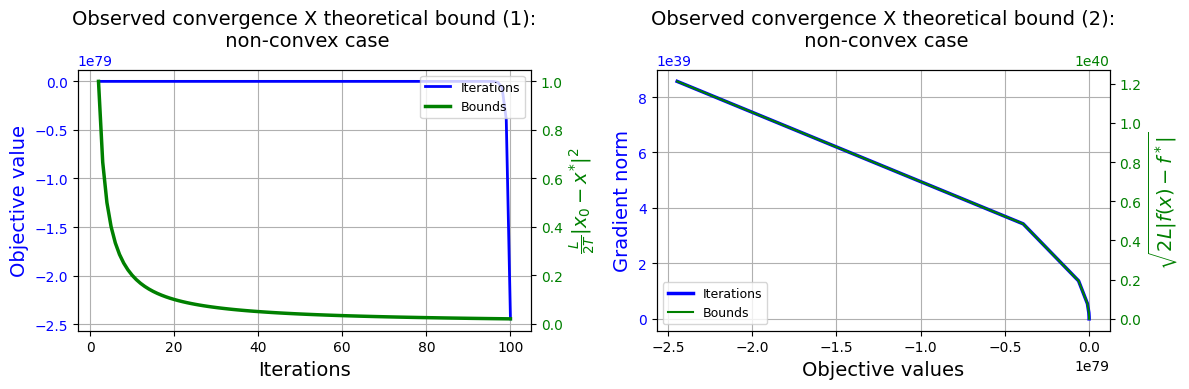

In [55]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4)) 

# Plot da relação entre iteração e valor da função objetivo (válido para os casos convexo e fortemente convexo)
ax1.plot(iterations, finalObjectiveValues, label='Iterations', color='blue', linewidth=2)
ax1.set_xlabel('Iterations', fontsize=14)
ax1.set_ylabel('Objective value', fontsize=14, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax1_twin = ax1.twinx()
ax1_twin.plot(iterations, maxEig / 2 * np.linalg.norm(initialPoint)**2 * (1 / np.array(iterations)), 
              label='Bounds', color='green', linewidth=2.5)
ax1_twin.set_ylabel('$\\frac{L}{2T}|x_0 - x^{*}|^2$', fontsize=14, color='green')
ax1_twin.tick_params(axis='y', labelcolor='green')

ax1.set_title('Observed convergence X theoretical bound (1):\n non-convex case', fontsize=14)
ax1.grid(True)

lines1 = ax1.get_lines() + ax1_twin.get_lines()
labels1 = [line.get_label() for line in lines1]
ax1.legend(lines1, labels1, fontsize=9, loc='upper right')



# Plot da relação entre norma do gradiente e valor da função objetivo (válido para caso fortemente convexo)
ax2.plot(finalObjectiveValues, np.array(finalGradientNorms), label='Iterations', color='blue', linewidth=2.5)
ax2.set_xlabel('Objective values', fontsize=14)
ax2.set_ylabel('Gradient norm', fontsize=14, color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

ax2_twin = ax2.twinx()
ax2_twin.plot(finalObjectiveValues, np.sqrt(2 * minEig * np.array(finalObjectiveValues)), 
              label='Bounds', color='green', linewidth=1.5)
ax2_twin.set_ylabel('$\\sqrt{2L|f(x) - f^*|}$', fontsize=14, color='green')
ax2_twin.tick_params(axis='y', labelcolor='green')

ax2.set_title('Observed convergence X theoretical bound (2):\n non-convex case', fontsize=14)
ax2.grid(True)

lines2 = ax2.get_lines() + ax2_twin.get_lines()
labels2 = [line.get_label() for line in lines2]
ax2.legend(lines2, labels2, fontsize=9, loc='lower left')



plt.tight_layout()
plt.show()

Vemos que, após um certo momento, utilizando um passo constante proporcional ao maior autovalor, o algoritmo diverge rapidamente após um certo número de iterações. Essa divergência seria ainda mais pronunciada se usássemos uma estratégia de passo proporcional à norma do gradiente, já que nessa hipótese o tamanho do passo em si também divergiria.

## Comportamento para diversos números de condição diferentes

O objetivo dessa próxima seção é gerar conjuntos de Hessianas aleatórias, cujos números de condicionamento são progressivamente maiores. Poderemos então avaliar algumas métricas de performance do algoritmo em função do condicionamento da função objetivo. Iremos fazer a análise para os casos convexo e fortemente convexo. O não-convexo não apresenta muito interesse à princípio pois irá sempre divergir independente de condicionamento, mudando somente o ritmo dessa divergência.

In [70]:
samples = 1000
conditionNumbers = []
finalGradientNorms = []
finalObjectiveValues = []
iterations = []
maxEigs = []

gradientNormStop = 1e-3
maxSteps = 1000
initialPoint = np.array([1,1])
useGradientStop = True

for q11 in range(4, 4+samples):    

    # Preparando função fortemente convexa
    Q = np.array([[q11, 0],[0, 3]])
    b = np.array([0,0])
    c = 0
    objective = QuadraticFunction
    objectiveGradient = QuadraticGradient
    
    # Calculando constante de Lipschitz  
    eigValues, eigvectors = np.linalg.eig(Q)
    maxEig = np.max(eigValues)
    minEig = np.min(eigValues)
    stepSize = 1/maxEig

    # Iteração zero do algoritmo
    point = initialPoint
    gradient = objectiveGradient(point, Q, b)
    gradientNorm = np.linalg.norm(gradient)
    objectiveValue = objective(point, Q, b, c)

    iter = 1
    while iter < maxSteps and (gradientNorm > gradientNormStop and useGradientStop):

        point = point - stepSize*gradient
        gradient = objectiveGradient(point, Q, b)
        gradientNorm = np.linalg.norm(gradient)
    
        iter = iter + 1
        
    conditionNumbers.append(maxEig/minEig)
    finalGradientNorms.append(gradientNorm)
    finalObjectiveValues.append(objective(point, Q, b, c))
    iterations.append(iter)
    maxEigs.append(maxEig)

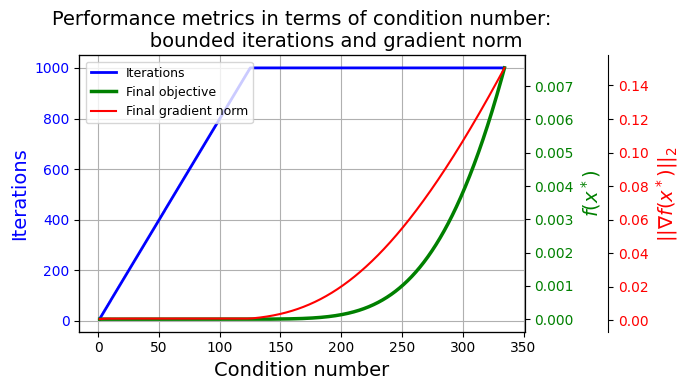

In [71]:
# Create the plot
fig, ax1 = plt.subplots(figsize=(7, 4))

# Plot the first curve
ax1.plot(conditionNumbers, iterations, label='Iterations', color='blue', linewidth=2)
ax1.set_xlabel('Condition number', fontsize=14)
ax1.set_ylabel('Iterations', fontsize=14, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(conditionNumbers, finalObjectiveValues, label='Final objective', color='green', linewidth=2.5)
ax2.set_ylabel('$f(x^*)$', fontsize=14, color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Create a third y-axis
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset the third axis
ax3.plot(conditionNumbers, finalGradientNorms, label='Final gradient norm', color='red', linewidth=1.5)
ax3.set_ylabel('$|| \\nabla f(x^*) ||_2$', fontsize=14, color='red')
ax3.tick_params(axis='y', labelcolor='red')

# Add a title and grid
plt.title('Performance metrics in terms of condition number:\n \
          bounded iterations and gradient norm', fontsize=14)
ax1.grid(True)

# Add a legend
lines = ax1.get_lines() + ax2.get_lines() + ax3.get_lines()
labels = [line.get_label() for line in lines]
plt.legend(lines, labels, fontsize=9, loc='upper left')

# Display the plot
plt.tight_layout()
plt.show()


O número de iterações necessárias para se alcançar o valor mínimo pre-estabelecido para o gradiente aumenta linearmente de início, o que é o esperado visto a dependência linear da taxa de convergência em relação ao número de condição da função objetivo. Sabemos que para funções fortemente convexas e um algoritmo com passo $1/L$, temos:

$$ f(x_T) - f(x^*) \leq \left( 1 - \frac{m}{L} \right)^T(f(x_0)-f(x^*)) $$ 

Após alcançarmos o teto de iterações do algoritmo, a melhor solução encontrada piora de maneira crescente, mas não consegui ainda fazer o link com alguma relação de convergência específica vista no curso ou no livro. 

### Idem ao anterior, porém com funções convexas com um dos autovalores nulos:

Aqui, o meu método para gerar matrizes aleatórias a partir dos autovalores ocasionalmente gerava Hessianas de funções não-convexas (provavelmente por conta de erros numéricos), e estava obtendo valores negativos para a função objetivo (sendo que é uma quadrática sem termos lineares). Optei então por utilizar um autovalor apenas próximo a zero em um dos autovalores.

In [58]:
samples = 100
conditionNumbers = []
finalGradientNorms = []
finalObjectiveValues = []
iterations = []
maxEigs = []

gradientNormStop = 1e-3
maxSteps = 3000
# initialPoint = np.random.random_sample(2)
initialPoint = np.array([1,1])
useGradientStop = True

for positiveEigValue in [i for i in range(1, 1+samples)]:    

    # Preparando função fortemente convexa
    Q = GenerateMatrixFromEigValues([positiveEigValue, 0.01])
    b = np.array([0,0])
    c = 0
    objective = QuadraticFunction
    objectiveGradient = QuadraticGradient
    
    # Calculando constante de Lipschitz  
    eigValues, eigvectors = np.linalg.eig(Q)
    maxEig = np.max(eigValues)
    stepSize = 1/maxEig

    # Iteração zero do algoritmo
    point = initialPoint
    gradient = objectiveGradient(point, Q, b)
    gradientNorm = np.linalg.norm(gradient)
    objectiveValue = objective(point, Q, b, c)

    iter = 1
    while iter < maxSteps and (gradientNorm > gradientNormStop and useGradientStop):
        point = point - stepSize*gradient
        gradient = objectiveGradient(point, Q, b)
        gradientNorm = np.linalg.norm(gradient)
    
        iter = iter + 1

    conditionNumbers.append(positiveEigValue)
    finalGradientNorms.append(gradientNorm)
    finalObjectiveValues.append(objective(point, Q, b, c))
    iterations.append(iter)
    maxEigs.append(maxEig)

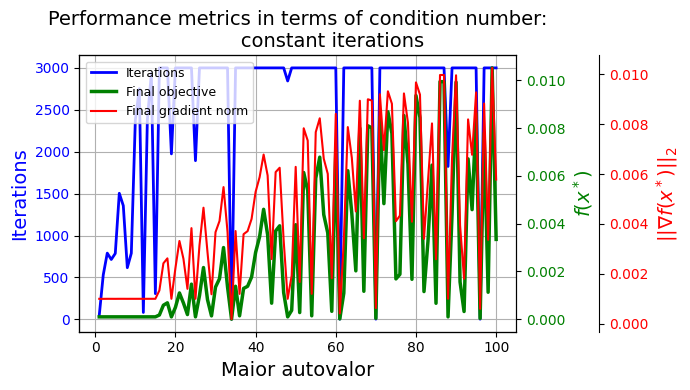

In [59]:
# Create the plot
fig, ax1 = plt.subplots(figsize=(7, 4))

# Plot the first curve
ax1.plot(conditionNumbers, iterations, label='Iterations', color='blue', linewidth=2)
ax1.set_xlabel('Maior autovalor', fontsize=14)
ax1.set_ylabel('Iterations', fontsize=14, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(conditionNumbers, finalObjectiveValues, label='Final objective', color='green', linewidth=2.5)
ax2.set_ylabel('$f(x^*)$', fontsize=14, color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Create a third y-axis
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset the third axis
ax3.plot(conditionNumbers, finalGradientNorms, label='Final gradient norm', color='red', linewidth=1.5)
ax3.set_ylabel('$|| \\nabla f(x^*) ||_2$', fontsize=14, color='red')
ax3.tick_params(axis='y', labelcolor='red')

# Add a title and grid
plt.title('Performance metrics in terms of condition number:\n \
          constant iterations', fontsize=14)
ax1.grid(True)

# Add a legend
lines = ax1.get_lines() + ax2.get_lines() + ax3.get_lines()
labels = [line.get_label() for line in lines]
plt.legend(lines, labels, fontsize=9, loc='upper left')

# Display the plot
plt.tight_layout()
plt.show()

Os resultados nos mostram um comportamento bem instável na busca do ótimo. O número de iterações necessárias para se chegar no gradiente mínimo parece crescer linearmente até o ponto em que o limite máximo de iterações entra em ação. Após isso, a qualidade do resultado piora, mas não exponencialmente como visto no caso fortemente convexo. 

É possível que isso tenha a ver com a escolha do tamanho do passo (o maior autovalor) ? Também não sei explicar o comportamento oscilatório das métricas obtidas em função do maior autovalor. 

## Plot de exemplos de funções fortemente convexas, convexas e não convexas  

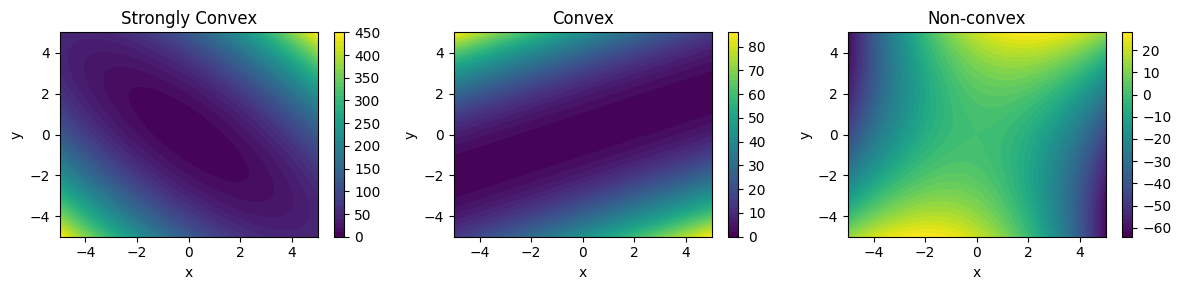

In [60]:
# Computing each type of quadratic
QStronglyConvex, b1, c1 = np.array([[1,2], [2,1]]), np.array([0,0]), 0
QStronglyConvex = QStronglyConvex @ QStronglyConvex
QConvex, b2, c2 = GeneratePSDMatrix(2), np.array([0,0]), 0
QNonConvex, b3, c3 = GenerateMatrixFromEigValues(np.array([1,-2])), np.array([0,0]), 0

x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
grid = np.stack([X.ravel(), Y.ravel()], axis=1)  # Flattened grid for computation

# Compute function values for each quadratic function
Z1 = np.array([QuadraticFunction(pt, QStronglyConvex, b1, c1) for pt in grid]).reshape(X.shape)
Z2 = np.array([QuadraticFunction(pt, QConvex, b2, c2) for pt in grid]).reshape(X.shape)
Z3 = np.array([QuadraticFunction(pt, QNonConvex, b3, c3) for pt in grid]).reshape(X.shape)

# Plot side-by-side contour plots
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

# Quadratic Function 1
contour1 = axs[0].contourf(X, Y, Z1, levels=50, cmap="viridis")
axs[0].set_title("Strongly Convex")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
fig.colorbar(contour1, ax=axs[0])

# Quadratic Function 2
contour2 = axs[1].contourf(X, Y, Z2, levels=50, cmap="viridis")
axs[1].set_title("Convex")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
fig.colorbar(contour2, ax=axs[1])

# Quadratic Function 3
contour3 = axs[2].contourf(X, Y, Z3, levels=50, cmap="viridis")
axs[2].set_title("Non-convex")
axs[2].set_xlabel("x")
axs[2].set_ylabel("y")
fig.colorbar(contour3, ax=axs[2])

plt.tight_layout()
plt.show()

## Gradiente descendente com busca em linha exata

# Parte 2: classificação multinomial no dataset MNIST

## Cáculo do gradiente da função objetivo softmax

A função softmax é dada por:

$$ \text{softmax}(x)_i = \gamma_i = \frac{\exp(x_i)}{\sum_{j}\exp(x_j)} $$ 

Derivando em relação à k-ésima componente, temos:
$$ \frac{\partial \gamma_i}{\partial x_j} = \left[ \sum_j \exp(x_j) \right]^{-2} \left[ \frac{\partial}{\partial x_k} \exp(x_i)\sum_j\exp(x_j) - \exp(x_i)\sum_j\frac{\partial}{\partial x_k}\exp(x_j) \right] $$

Usando agora o fato de que $ \frac{\partial}{x_i}\exp(x_j) = \delta_{ij}\exp(x_i)$, obtemos:

$$ \frac{\partial \gamma_i}{\partial x_j} = \left[ \sum_j \exp(x_j) \right]^{-2} \left[ \sum_j\delta_{ki}\exp(x_k)\exp(x_j) - \exp(x_i)\delta_{jk}\exp(x_k) \right] $$
$$ = \frac{\delta_{ki}\exp(x_k)}{\sum_j\exp(x_j)} - \frac{\exp(x_i\exp(x_k))}{\left[ \sum_j\exp(x_j) \right]} = \delta_{ki}\gamma_k - \gamma_i\gamma_k = \gamma_i(\delta_{ki}-\gamma_k)$$

É importante notear que usualmente a função custo para a regressão logística multinomial é a entropia cruzada da função softmax. nesse caso, podemos usar a regra da cadeia para obter o gradiente que será efetivamente usado no algoritmo. Sabendo que a entropia cruzada é dada por $ -\sum_i y_i\log(\gamma_i) $, e devemos considerar que na notação utilizada aqui, nossa variável é na verdade os componentes dos vetores de separação das classes ($x_i \rightarrow w_i^{T}x$, sendo $x$ o vetor de features de treino e $w$ os parâmetros do classificador). Temos então no final:

$$ \frac{\partial L}{\partial w_k} = \sum_i \frac{\partial L}{\partial \gamma_i} \frac{\partial \gamma_i}{\partial x} \frac{\partial x}{\partial w_k} = x(\delta(y=k)-\gamma_k).$$ 


De forma mais explícita, as expressões podem ser escritas como:

$$ L(w) = -\left[ \sum_{i=1}^{m}\sum_{k=1}^{K} \delta(y_i=k) \log \left( \frac{\exp ({w_k}^Tx^i)}{\sum_{j=1}^{K}\exp({w_j}^Tx^i)} \right) \right], $$

$$ \nabla_{w^k}L(w) = -\sum_{i=1}^{m} \left[ x^i \left(\delta (y_i=k) - \frac{\exp ({w_k}^Tx^i)}{\sum_{j=1}^{K}\exp({w_j}^Tx^i)} \right) \right] $$ 

onde $K$ denota o número de classificações possíveis, e $m$ o total de dados de treino.

## Carregando base de dados MNIST e preparando conjuntos de treino/teste

Para que os cálculos possam ser feitos de maneira vetorizada mais facilmente à frente, vamos converter as matrizes de features em um vetor unidimensional, e codificaremos as classes usando one-hot encoding. 

In [61]:
# Carregando dados 
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()


# Convertendo matrizes de pixels em uma lista 
x_train = np.array([array.reshape(-1) for array in x_train])
x_test = np.array([array.reshape(-1) for array in x_test])


# One-hot enconding para a classificação de cada dado
y_train = np.eye(10, dtype=int)[y_train]
y_test = np.eye(10, dtype=int)[y_test]


# Normalização dos dados de clareza dos pixels para o intervalo [0,1]
x_train, x_test = (x_train) / 255, (x_test) / 255

In [62]:
# Checando formato dos dados
print(x_train.shape)
print(y_train.shape)

(60000, 784)
(60000, 10)


## Definindo funções necessárias para realizar e avaliar a classificação

In [63]:
# Definindo funções custo e gradiente para o problema de classificação multinomial

def Softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True)) 
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def LossFunction(x, y):
    # Para a otmização em si, usaremos a média da loss function para cada classe do problema
    s = Softmax(x)
    return -np.sum(y * np.log(s)) / x.shape[0]  

def Gradient(x, wTx, y):
    s = Softmax(wTx)
    return (x.T @ (s - y)) / x.shape[0]


# Funções para avaliação de performance
def ComputePrediction(x, w):
    probabilities = Softmax(x @ w)
    return np.argmax(probabilities, axis=1) 

def ComputeAccuracy(predictions, labels):
    return np.mean(predictions == labels) * 100

## Rodando o gradiente descendente não-estocástico e estocástico:

Para a implementação do caso estocástico, decidi adicionar um vetor aleatório ao gradiente, cuja norma é proporcional à norma do gradiente sem si. Essa proporção é controlada pelo parâmetro 'stochasticity': quando nulo, o algoritmo se resume ao gradiente descendente simples. A implementação do gradiente estocástico abaixo foi feita com esse parâmetro settado em 0.1.

### Gradiente simples

In [64]:
# Dimensões relevantes
K = y_train.shape[1]
n = x_train.shape[1]

# Parâmetros da descida de gradiente. 
gradientNormStop = 1e-3
maxSteps = 1000
learningRate = 0.1
stochasticity = 0.0

conditionNumbers = []
gradientNorms = []
objectiveValues = []
iterations = []
maxEigs = []

objective = LossFunction
objectiveGradient = Gradient

iter = 1
gradientNorm = np.inf
w = np.random.random_sample((n, K))

while iter < maxSteps and gradientNorm > gradientNormStop:

    wTx = x_train @ w
    grad = objectiveGradient(x_train, wTx, y_train)
    gradientNorm = np.linalg.norm(grad)
    w -= learningRate * (grad + stochasticity * gradientNorm * np.random.random_sample(grad.shape))  # Update weights
    loss = objective(wTx, y_train)
    
    iter += 1
    
    if iter%100 == 0:
        print(f"At iteration {iter}: objective = {loss:.4f}, gradient norm = {gradientNorm:.4f}")
        
    gradientNorms.append(gradientNorm)
    objectiveValues.append(loss)
    iterations.append(iter)


At iteration 100: objective = 0.8233, gradient norm = 0.2023
At iteration 200: objective = 0.6085, gradient norm = 0.1066
At iteration 300: objective = 0.5296, gradient norm = 0.0743
At iteration 400: objective = 0.4865, gradient norm = 0.0580
At iteration 500: objective = 0.4586, gradient norm = 0.0482
At iteration 600: objective = 0.4386, gradient norm = 0.0415
At iteration 700: objective = 0.4234, gradient norm = 0.0367
At iteration 800: objective = 0.4113, gradient norm = 0.0330
At iteration 900: objective = 0.4014, gradient norm = 0.0301
At iteration 1000: objective = 0.3930, gradient norm = 0.0277


In [65]:
testPredictions = ComputePrediction(x_test, w)
realLabels = np.argmax(y_test, axis=1)  
testAccuracy = ComputeAccuracy(testPredictions, realLabels)

print(f"Test Accuracy: {testAccuracy:.2f}%")

Test Accuracy: 89.07%


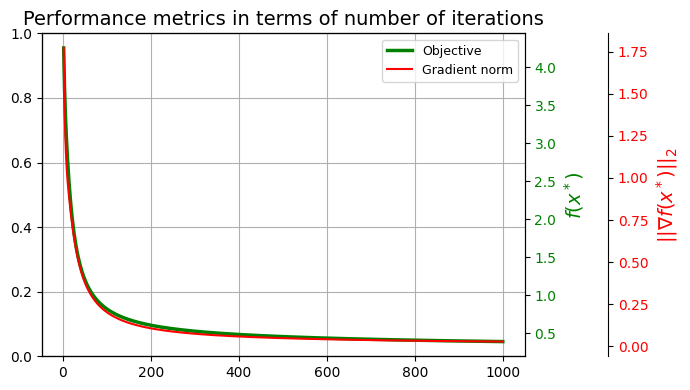

In [66]:
# Create the plot
fig, ax1 = plt.subplots(figsize=(7, 4))

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(iterations, objectiveValues, label='Objective', color='green', linewidth=2.5)
ax2.set_ylabel('$f(x^*)$', fontsize=14, color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Create a third y-axis
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset the third axis
ax3.plot(iterations, gradientNorms, label='Gradient norm', color='red', linewidth=1.5)
ax3.set_ylabel('$|| \\nabla f(x^*) ||_2$', fontsize=14, color='red')
ax3.tick_params(axis='y', labelcolor='red')

# Add a title and grid
plt.title('Performance metrics in terms of number of iterations', fontsize=14)
ax1.grid(True)

# Add a legend
lines = ax1.get_lines() + ax2.get_lines() + ax3.get_lines()
labels = [line.get_label() for line in lines]
plt.legend(lines, labels, fontsize=9, loc='upper right')

# Display the plot
plt.tight_layout()
plt.show()

### Gradiente estocástico

In [67]:
# Dimensões relevantes
K = y_train.shape[1]
n = x_train.shape[1]

# Parâmetros da descida de gradiente. 
gradientNormStop = 1e-3
maxSteps = 1000
learningRate = 0.1
stochasticity = 0.1

conditionNumbers = []
gradientNorms = []
objectiveValues = []
iterations = []
maxEigs = []

objective = LossFunction
objectiveGradient = Gradient

iter = 1
gradientNorm = np.inf
w = np.random.random_sample((n, K))

while iter < maxSteps and gradientNorm > gradientNormStop:

    wTx = x_train @ w
    grad = objectiveGradient(x_train, wTx, y_train)
    gradientNorm = np.linalg.norm(grad)
    w -= learningRate * (grad + stochasticity * gradientNorm * np.random.random_sample(grad.shape))  # Update weights
    loss = objective(wTx, y_train)

    iter += 1
    
    if iter%100 == 0:
        print(f"At iteration {iter}: objective = {loss:.4f}, gradient norm = {gradientNorm:.4f}")
    
    gradientNorms.append(gradientNorm)
    objectiveValues.append(loss)
    iterations.append(iter)


At iteration 100: objective = 0.8786, gradient norm = 0.2113
At iteration 200: objective = 0.6431, gradient norm = 0.1122
At iteration 300: objective = 0.5553, gradient norm = 0.0786
At iteration 400: objective = 0.5072, gradient norm = 0.0615
At iteration 500: objective = 0.4759, gradient norm = 0.0510
At iteration 600: objective = 0.4535, gradient norm = 0.0439
At iteration 700: objective = 0.4366, gradient norm = 0.0388
At iteration 800: objective = 0.4230, gradient norm = 0.0348
At iteration 900: objective = 0.4120, gradient norm = 0.0317
At iteration 1000: objective = 0.4028, gradient norm = 0.0292


In [68]:
testPredictions = ComputePrediction(x_test, w)
realLabels = np.argmax(y_test, axis=1)  
testAccuracy = ComputeAccuracy(testPredictions, realLabels)

print(f"Test Accuracy: {testAccuracy:.2f}%")


Test Accuracy: 88.77%


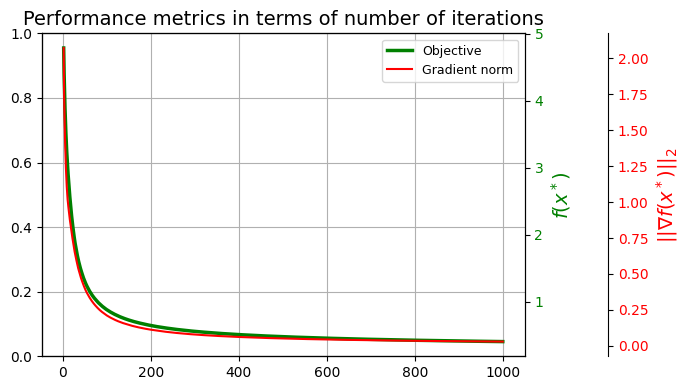

In [69]:
# Create the plot
fig, ax1 = plt.subplots(figsize=(7, 4))

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(iterations, objectiveValues, label='Objective', color='green', linewidth=2.5)
ax2.set_ylabel('$f(x^*)$', fontsize=14, color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Create a third y-axis
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset the third axis
ax3.plot(iterations, gradientNorms, label='Gradient norm', color='red', linewidth=1.5)
ax3.set_ylabel('$|| \\nabla f(x^*) ||_2$', fontsize=14, color='red')
ax3.tick_params(axis='y', labelcolor='red')

# Add a title and grid
plt.title('Performance metrics in terms of number of iterations', fontsize=14)
ax1.grid(True)

# Add a legend
lines = ax1.get_lines() + ax2.get_lines() + ax3.get_lines()
labels = [line.get_label() for line in lines]
plt.legend(lines, labels, fontsize=9, loc='upper right')

# Display the plot
plt.tight_layout()
plt.show()

Conseguimos obter uma taxa de acertos de quase 90% na classificação (mais de 90% é possível aumentando o valor da taxa de aprendizagem e número de iterações). Foi observado que, com uma taxa de aprendizagem de 0.1 e 1000 iterações totais, a acurácia do gradiente simples e estocástico foram muito similares (88.68% e 88.79% respectivamente). Algumas observações me mostraram que valores muito maiores de estocasticidade em geral reduzem a eficácia do algoritmo. 

Seria interessante experimentar diferentes distribuições no ruído adicionado (aqui utilizei somente a função random_sample do numpy, que gera vetores com base em uma ditribuição uniforme), para ver se alguma estratégia apresenta melhoras significativas em relação ao gradiente convencional. 